# The old six sigma

Allen Downey 2019

[MIT License](https://en.wikipedia.org/wiki/MIT_License)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from empiricaldist import Pmf

from utils import decorate

In [3]:
# https://finance.yahoo.com/quote/%5EDJI/history?period1=475822800&period2=1565150400&interval=1d&filter=history&frequency=1d

#df = pd.read_csv('yahoo/yahoo_djia.csv')
#df.shape

In [4]:
# https://finance.yahoo.com/quote/%5EGSPC/history?period1=-630961200&period2=1565150400&interval=1d&filter=history&frequency=1d

df = pd.read_csv('yahoo/yahoo_sp500.csv')
df.shape

(17511, 7)

In [5]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1950-01-03,16.66,16.66,16.66,16.66,16.66,1260000
1,1950-01-04,16.85,16.85,16.85,16.85,16.85,1890000
2,1950-01-05,16.93,16.93,16.93,16.93,16.93,2550000
3,1950-01-06,16.98,16.98,16.98,16.98,16.98,2010000
4,1950-01-09,17.08,17.08,17.08,17.08,17.08,2520000


In [6]:
change = df['Open'].diff() / df['Open'] * 100
change = change.dropna()
change.shape

(17510,)

In [6]:
from empiricaldist import Cdf

cdf = Cdf.from_seq(change)

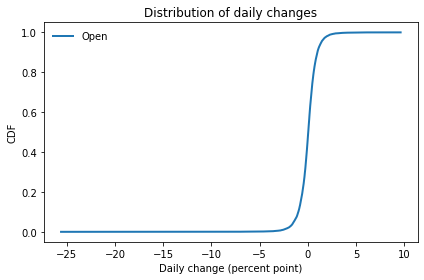

In [7]:
cdf.plot()
decorate(xlabel='Daily change (percent point)',
         ylabel='CDF',
         title='Distribution of daily changes')

In [8]:
from scipy.stats import norm

def make_model(sample, size=201):
    mu = np.mean(sample)
    sigma = np.std(sample)
    model = norm(mu, sigma)

    xs = np.linspace(np.min(sample), np.max(sample), size)
    ys = model.cdf(xs)
    return xs, ys

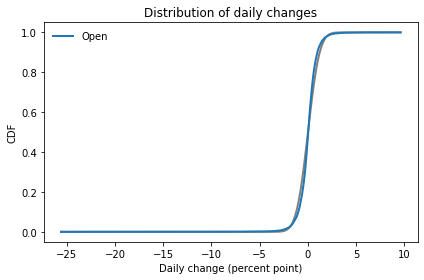

In [9]:
xs, ys = make_model(change)

plt.plot(xs, ys, color='gray')
cdf.plot()
decorate(xlabel='Daily change (percent point)',
         ylabel='CDF',
         title='Distribution of daily changes')

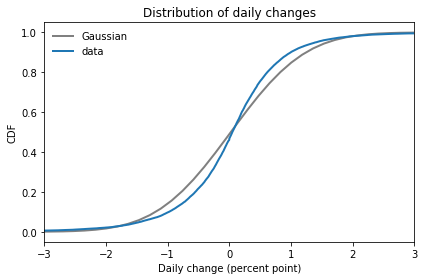

In [10]:
plt.plot(xs, ys, color='gray', label='Gaussian')
cdf.plot(label='data')
decorate(xlim=[-3, 3],
         xlabel='Daily change (percent point)',
         ylabel='CDF',
         title='Distribution of daily changes')

In [11]:
def make_normal_prob_plot(sample):
    xs = norm.rvs(size=len(sample))
    xs = np.sort(xs)
    ys = np.sort(sample)
    
    span = min(xs), max(xs)
    plt.plot(span, span, color='gray', alpha=0.5)
    plt.plot(xs, ys)

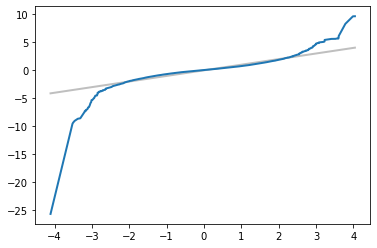

In [12]:
make_normal_prob_plot(change)

In [13]:
from empiricaldist import Surv

def tail_plot(sample):
    xs, ys = make_model(sample)
    plt.plot(xs, 1-ys, color='gray', label='Gaussian')

    # when we plot y on a log scale, we lose the
    # most extreme value
    surv = Surv.from_seq(sample)
    surv.replace(0, np.nan, inplace=True)
    surv.plot(label='data')
    
    decorate(xscale='log', 
             yscale='log',
             xlabel='Daily change (log percent point)',
             ylabel='CCDF (log)')
    
    return surv

In [14]:
def resample(sample, ncols=101):
    nrows = len(sample)
    array = np.random.choice(sample, (nrows, ncols))
    return pd.DataFrame(array)

In [15]:
def plot_surv_confidence(index, samples, **options):
    df = pd.DataFrame(index=index, columns=samples.columns)
    for i in samples.columns:
        surv = Surv.from_seq(samples[i])
        surv.replace(0, np.nan, inplace=True)
        df[i] = surv(index)
    
    df.fillna(method='ffill', inplace=True)
    df.values.sort()
    
    nrows, ncols = df.shape
    low = int(ncols * 0.05)
    high = int(ncols * 0.95)
    plt.fill_between(df.index, df[low], df[high], **options)

In [16]:
from matplotlib.ticker import NullFormatter

def set_xticks(locs, labels):
    ax = plt.gca()
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.xaxis.set_minor_formatter(NullFormatter())
    plt.xticks(locs, labels)

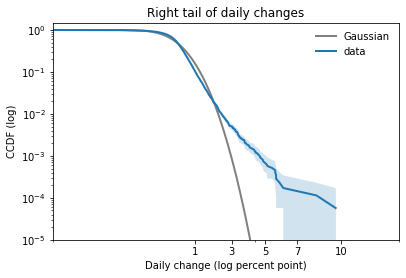

In [17]:
shift = np.min(change)
right_tail = change - shift

surv = tail_plot(right_tail)

samples = resample(right_tail, 101)
plot_surv_confidence(surv.index, samples, alpha=0.2)

decorate(title='Right tail of daily changes',
         xlim=[20, 40],
         ylim=[1e-5, 1.5])

labels = [1, 3, 5, 7, 10]

labels = np.array([1, 3, 5, 7, 10])
locs = labels - shift
set_xticks(locs, labels)

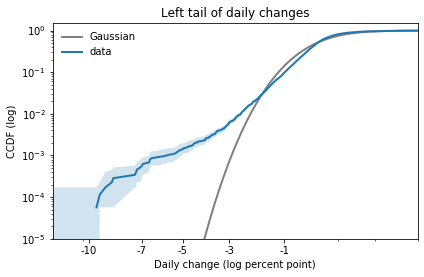

In [18]:
shift = np.max(change)
left_tail = shift - change

surv = tail_plot(left_tail)

samples = resample(left_tail, 101)
plot_surv_confidence(surv.index, samples, alpha=0.2)

decorate(title='Left tail of daily changes', 
         xlim=[7, 22],
         ylim=[1e-5, 1.5])

plt.gca().invert_xaxis()

labels = np.array([-1, -3, -5, -7, -10])
locs = shift - labels
set_xticks(locs, labels)

Bayesian analysis adapted from 
https://towardsdatascience.com/bayesian-modeling-airlines-customer-service-twitter-response-time-74af893f02c0

In [19]:
import pymc3 as pm

# Normal model
with pm.Model() as model_t:
    μ = pm.Uniform('μ', lower=0, upper=60)
    σ = pm.HalfNormal('σ', sd=10)
    y = pm.Normal('y', mu=μ, sd=σ, observed=change)
    trace_t = pm.sample(2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, μ]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:08<00:00, 915.66draws/s] 


In [20]:
import pymc3 as pm

# Student T model
with pm.Model() as model_t:
    μ = pm.Uniform('μ', lower=0, upper=60)
    s = pm.HalfNormal('s', sd=10)
    ν = pm.Exponential('ν', 1/1)
    y = pm.StudentT('y', mu=μ, sd=s, nu=ν, observed=change)
    trace_t = pm.sample(2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ν, s, μ]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:24<00:00, 322.89draws/s]


In [21]:
import pymc3 as pm

# Mixture of Gaussian model (equivalent to Student T?)
with pm.Model() as model_t:
    μ = pm.Uniform('μ', lower=0, upper=60)
    s = pm.HalfNormal('s', sd=10)
    ν = pm.Exponential('ν', 1/1)
    
    var = pm.InverseGamma('var', alpha = ν / 2, beta = ν * s**2 / 2)
    y = pm.Normal('y', mu=μ, sd=np.sqrt(var), observed=change)
    trace_t = pm.sample(2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [var, ν, s, μ]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:17<00:00, 463.33draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [7]:
import pymc3 as pm
import theano.tensor as tt

# Mixture of Gaussian model (equivalent to Student T?)
with pm.Model() as model_t:
    μ = pm.Uniform('μ', lower=0, upper=60)
    s = pm.HalfNormal('s', sd=10)
    ν = pm.Exponential('ν', 1/1)
    
    tau2 = pm.Gamma('tau2', alpha = ν / 2, beta = ν * s**2 / 2)
    y = pm.Normal('y', mu=μ, tau=tt.sqrt(tau2), observed=change)
    trace_t = pm.sample(2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau2, ν, s, μ]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:16<00:00, 497.23draws/s]


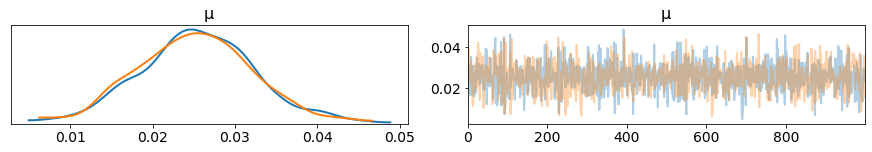

In [8]:
import arviz as az

az.plot_trace(trace_t[:1000], var_names = ['μ']);

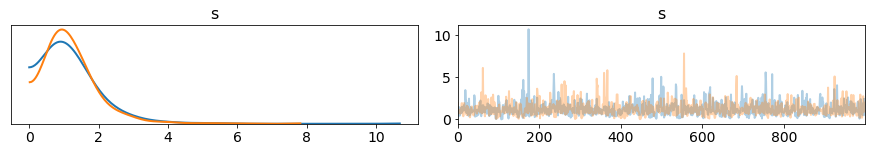

In [9]:
az.plot_trace(trace_t[:1000], var_names = ['s']);

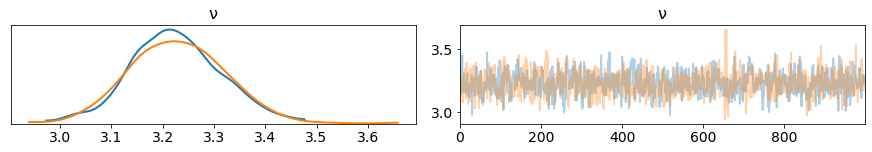

In [100]:
az.plot_trace(trace_t[:1000], var_names = ['ν']);

In [101]:
ppc = pm.sample_posterior_predictive(trace_t, samples=101, model=model_t)

100%|██████████| 101/101 [00:00<00:00, 268.91it/s]


In [102]:
samples = pd.DataFrame(np.transpose(ppc['y']))
samples.shape

(17510, 101)

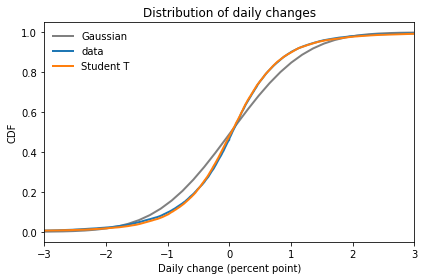

In [103]:
plt.plot(xs, ys, color='gray', label='Gaussian')
cdf.plot(label='data')
cdf_y = Cdf.from_seq(samples[0])
cdf_y.plot(label='Student T')
decorate(xlim=[-3, 3],
         xlabel='Daily change (percent point)',
         ylabel='CDF',
         title='Distribution of daily changes')

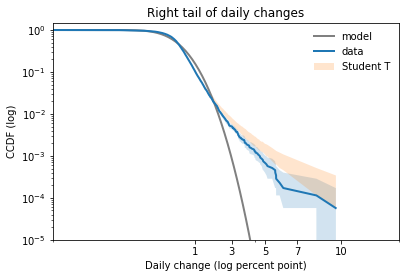

In [104]:
shift = np.min(change)
right_tail = change - shift

surv = tail_plot(right_tail)

samples = resample(right_tail, 101)
plot_surv_confidence(surv.index, samples, alpha=0.2)

samples = pd.DataFrame(np.transpose(ppc['y'])) - shift
plot_surv_confidence(surv.index, samples, 
                     alpha=0.2, 
                     label='Student T')

decorate(title='Right tail of daily changes',
         xlim=[20, 40],
         ylim=[1e-5, 1.5])

clear_xticks()
labels = np.array([1, 3, 5, 7, 10])
locs = labels - shift
plt.xticks(locs, labels);

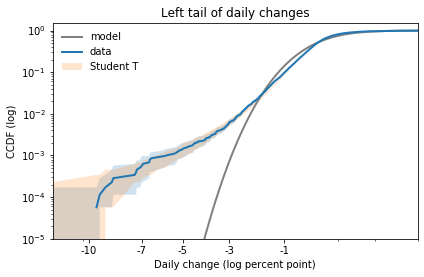

In [105]:
shift = np.max(change)
left_tail = shift - change

surv = tail_plot(left_tail)

samples = resample(left_tail, 101)
plot_surv_confidence(surv.index, samples, alpha=0.2)

samples = shift - pd.DataFrame(np.transpose(ppc['y']))
plot_surv_confidence(surv.index, samples, 
                     alpha=0.2, 
                     label='Student T')

decorate(title='Left tail of daily changes', 
         xlim=[7, 22],
         ylim=[1e-5, 1.5])

plt.gca().invert_xaxis()

clear_xticks()
labels = np.array([-1, -3, -5, -7, -10])
locs = shift - labels
plt.xticks(locs, labels);